c:\Users\Fernando\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0157 - val_loss: 0.0011
Epoch 2/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - val_loss: 6.4532e-04
Epoch 3/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 8.2228e-04
Epoch 4/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 9.0382e-04
Epoch 5/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 4.6664e-04
Epoch 6/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 5.6460e-04
Epoch 7/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 6.1356e-04
Epoch 8/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 8.6308e-04
Epoch 9/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 5.1373e-04
Epoch 10/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 5.7089e-04
Epoch 11/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - val_loss: 7.2215e-04
Epoch 12/400
38/38 ━━━

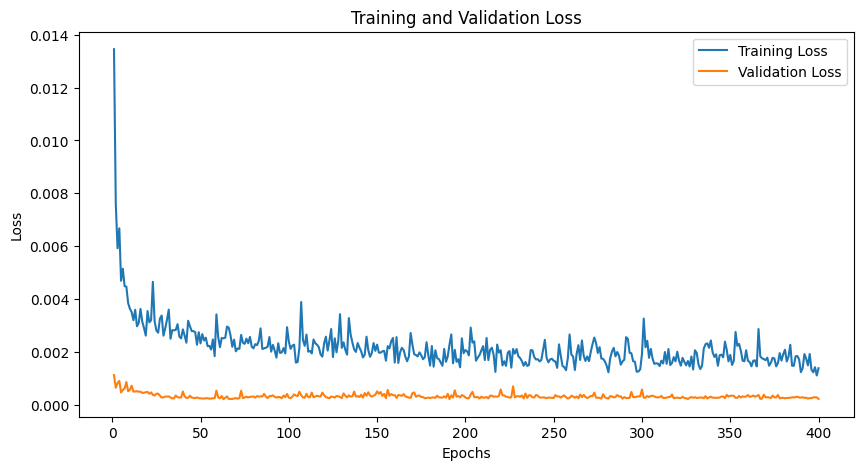

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Mean Squared Error Global: 59181290967987.59
R² Score Global: 0.6293209126562763


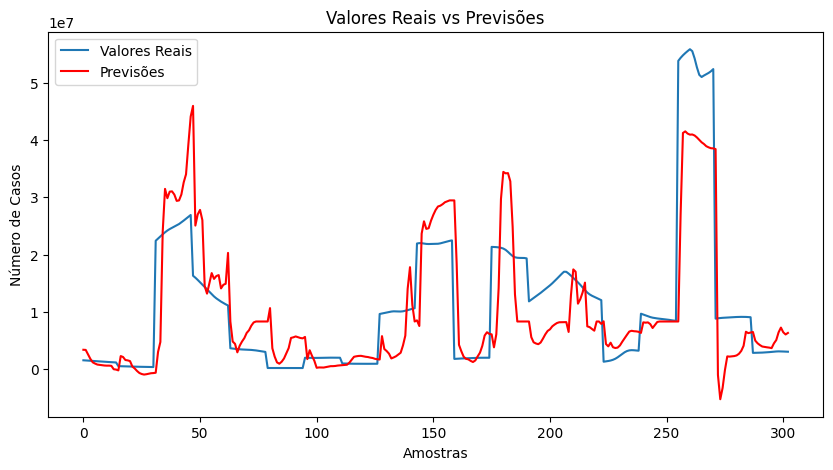

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Carregando o dataset (ajuste o caminho do arquivo CSV conforme necessário)
df = pd.read_csv('base_unificada_ate_2015.csv')

# Número de passos de tempo para olhar para trás
n_steps = 5

# Selecionar todas as colunas relevantes (exceto 'Local' e 'Ano') como features
features = df[['BCG', 'Hib3', 'DTP3', 'Saneamento Seguro (%)',
               'Numero Total de Imigrantes', 'Gini (Indice de Desigualdade no Pais)',
               'Populacao', 'Taxa de Extrema Pobreza (%)', 'Numero de Usuario de Internet']].values

# Selecionar a coluna de interesse para prever (número de infecções respiratórias e tuberculose)
target = df['Numero de Casos de Infeccoes Respiratorios e Tuberculose'].values.reshape(-1, 1)

# Normalizando os dados (tanto as features quanto o target)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# Função para criar os conjuntos de dados de treinamento e teste
def create_dataset(features, target, n_steps):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i + n_steps])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

# Criando os conjuntos de dados
X, y = create_dataset(scaled_features, scaled_target, n_steps)

# Dividindo em conjunto de treinamento e teste (80% para treino, 20% para teste)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape para o LSTM [amostras, passos de tempo, características]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_data=(X_test, y_test))

# Plot da perda
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Salvando o modelo treinado
model.save('modelo_lstm_global.h5')

# Fazendo previsões
y_pred = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred)
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculando métricas globais
mse_global = mean_squared_error(y_test, y_pred)
r2_global = r2_score(y_test, y_pred)

print(f'Mean Squared Error Global: {mse_global}')
print(f'R² Score Global: {r2_global}')

# Plotando os valores reais versus as previsões
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valores Reais')
plt.plot(y_pred, label='Previsões', color='red')
plt.title('Valores Reais vs Previsões')
plt.xlabel('Amostras')
plt.ylabel('Número de Casos')
plt.legend()
plt.show()
